In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
import sympy as sp
import matplotlib
from matplotlib.ticker import FuncFormatter
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Solving the model

#### Part 1: cytoplasm vs membrane

See Solve notebook.
Model 2 is the applicable one (others give nonsensical answers)

In [2]:
def model1(ka, km, alpha, d):
    return (-alpha**2*km**3 + alpha**2*km**2 + 4*alpha*d*ka*km**2 - alpha*km**2*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 + 2*alpha*km + 8*d*ka + 1) - alpha*km**2 + alpha*km*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 + 2*alpha*km + 8*d*ka + 1) + alpha*km + 4*d*ka)/(4*ka*(alpha**2*km**4 + 2*alpha*km**2 + 1))

def model2(ka, km, alpha, d):
    return (-alpha**2*km**3 + alpha**2*km**2 + 4*alpha*d*ka*km**2 + alpha*km**2*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 + 2*alpha*km + 8*d*ka + 1) - alpha*km**2 - alpha*km*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 + 2*alpha*km + 8*d*ka + 1) + alpha*km + 4*d*ka)/(4*ka*(alpha**2*km**4 + 2*alpha*km**2 + 1))

def model3(ka, km, alpha, d):
    return (alpha**2*km**3 + alpha**2*km**2 + 4*alpha*d*ka*km**2 - alpha*km**2*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 - 2*alpha*km + 8*d*ka + 1) - alpha*km**2 - alpha*km*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 - 2*alpha*km + 8*d*ka + 1) - alpha*km + 4*d*ka)/(4*ka*(alpha**2*km**4 + 2*alpha*km**2 + 1))

def model4(ka, km, alpha, d):
    return (alpha**2*km**3 + alpha**2*km**2 + 4*alpha*d*ka*km**2 + alpha*km**2*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 - 2*alpha*km + 8*d*ka + 1) - alpha*km**2 + alpha*km*np.sqrt(alpha**2*km**2 + 8*alpha*d*ka*km**2 - 2*alpha*km + 8*d*ka + 1) - alpha*km + 4*d*ka)/(4*ka*(alpha**2*km**4 + 2*alpha*km**2 + 1))

#### Part 2: Monomer vs dimer

In [3]:
def dimerisation(ka, tot):
    # Takes the total concentration, and returns the monomer concentration
    mon = (np.sqrt(8 * tot * ka + 1) - 1) / (4 * ka)
    return mon

### Parameters

In [4]:
D = 0.005451  # molecule diameter (um) (estimated based on mw)
svr = 0.174 # surface area to volume ratio (Goehring 2011)
Km = 2.5  # log 10 of default membrane binding constant
dos_max = 1.04e-8/(1-0.62) # maximum dosage to run down from (based on Gross 2018 and my estimates of membrane fraction)
print(dos_max)

2.736842105263158e-08


### Rundowns: log transformed

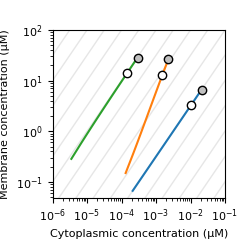

In [5]:
dosages = np.linspace(dos_max / 100, dos_max, 100)
select_energies = [2.5, 7.5, 12.5]

fig, ax = plt.subplots()

# Plot major lines
for d in select_energies:
    cyt = model2(10 ** d, 10 ** Km, alpha=svr*D, d=dosages)
    mem = (dosages - cyt) / (svr*D)
    ax.plot(np.log10(cyt), np.log10(mem))
    
# Plot full dosage points
for d in select_energies:
    cyt = model2(10 ** d, 10 ** Km, alpha=svr*D, d=dosages[-1])
    mem = (dosages[-1] - cyt) / (svr*D)
    ax.scatter(np.log10(cyt), np.log10(mem), c='silver', edgecolors='k', zorder=10)

# Plot half dosage points
for d in select_energies:
    cyt = model2(10 ** d, 10 ** Km, alpha=svr*D, d=dosages[-1]/2)
    mem = (dosages[-1]/2 - cyt) / (svr*D)
    ax.scatter(np.log10(cyt), np.log10(mem), c='w', edgecolors='k', zorder=10)

# Plot grid lines
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for i in np.arange(-10, 10, 0.5):
    ax.plot([-20, 0], [i - 10, i + 10], c='0.9', zorder=-100, linewidth=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

@FuncFormatter
def log_molar_to_micromolar(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%d}$' % (x+6)
    
ax.set_yticks([i for i in ax.get_yticks() if i % 1 == 0])
ax.set_xticks([i for i in ax.get_xticks() if i % 1 == 0])
ax.set_xlabel('Cytoplasmic concentration (µM)', fontsize=8)
ax.set_ylabel('Membrane concentration (µM)', fontsize=8)
ax.xaxis.set_major_formatter(log_molar_to_micromolar)
# ax.set_yticks([-2, -1, 0, 1])
ax.yaxis.set_major_formatter(log_molar_to_micromolar)
ax.tick_params(axis='both', labelsize=8)
minor_ticks(ax)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(bottom=0.21, left=0.21)
fig.savefig('Figs/rundowns_log.png', transparent=True, dpi=600)

### Effective exponent

In [6]:
resolution = 100
mem_energies_ = np.linspace(0, 5, resolution)
dim_energies_ = np.linspace(0, 15, resolution)
X, Y = np.meshgrid(mem_energies_, dim_energies_)

cyts = np.zeros([len(dosages), 100, 100])
mems = np.zeros([len(dosages), 100, 100])
for i, d in enumerate(dosages):
    cyts[i, :, :] = model2(10 ** Y, 10 ** X, alpha=svr*D, d=d)
    mems[i, :, :] = (d - cyts[i, :, :]) / (svr*D)   

res = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = cyts[:, i, j]
        y = mems[:, i, j]
        res[i, j] = np.polyfit(np.log10(x), np.log10(y), 1)[0]

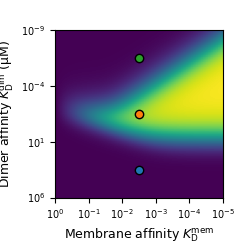

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5, 2.5)
extent = (min(mem_energies_), max(mem_energies_),min(dim_energies_), max(dim_energies_))
aspect = (extent[1] - extent[0]) / (extent[3] - extent[2])
ax.imshow(res, origin='lower', extent=extent, aspect=aspect, cmap='viridis', vmin=1, vmax=2)

for y in select_energies:
    ax.scatter(2.5, y, edgecolors='k')

@FuncFormatter
def log_ka_to_kd(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%d}$' % (-x)

@FuncFormatter
def log_ka_to_kd_molar_to_micromolar(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%d}$' % (-x+6)
    
ax.set_yticks([0, 5, 10, 15])
ax.set_xlabel('Membrane affinity ' + r'$K\mathrm{_D^{mem}}$', fontsize=9)
ax.set_ylabel('Dimer affinity ' + r'$K\mathrm{_D^{dim}}$' + ' (µM)', fontsize=9)
ax.xaxis.set_major_formatter(log_ka_to_kd)
ax.yaxis.set_major_formatter(log_ka_to_kd_molar_to_micromolar) 
ax.tick_params(axis='both', labelsize=7)
fig.subplots_adjust(bottom=0.21, left=0.21)
fig.savefig('Figs/exponents.png', transparent=True, dpi=600)

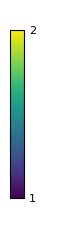

In [8]:
fig, ax = plt.subplots(figsize=(0.6, 2))
fig.set_size_inches(0.8, 2.5)
fig.subplots_adjust(bottom=0.21, right=0.3)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('viridis'), ticks=[0, 1])
cbar.ax.set_yticklabels(['1', '2'])
cbar.ax.tick_params(size=0, labelsize=8)
fig.savefig('Figs/exponents_cbar.png', transparent=True, dpi=600)

### Local concentration vs dimerisation

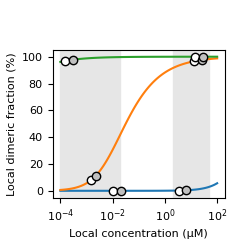

In [9]:
fig, ax = plt.subplots()
local_concentrations = np.linspace(-10, -4, 100)

# Major lines
for d in select_energies:
    
    # Dimer titration curve
    mon = dimerisation(ka=10 ** d, tot=10**local_concentrations)
    dim_frac = 100 * ((10 ** local_concentrations) - mon) / (10 ** local_concentrations)
    ax.plot(local_concentrations, dim_frac)
    
    # Cytoplasmic and membrane concentrations - full dosage
    cyt = model2(10 ** d, 10 ** Km, alpha=svr*D, d=dos_max)
    mem = (dos_max - cyt) / (svr*D)
    
    # Cytoplasmic and membrane dimerisation - full dosage
    cyt_mon = dimerisation(ka=10 ** d, tot=cyt)
    mem_mon = dimerisation(ka=10 ** d, tot=mem)
    cyt_dim_frac = 100 * (cyt - cyt_mon) / cyt
    mem_dim_frac = 100 * (mem - mem_mon) / mem
    ax.scatter(np.log10(cyt), cyt_dim_frac, zorder=10, c='silver', edgecolors='k')
    ax.scatter(np.log10(mem), mem_dim_frac, zorder=10, c='silver', edgecolors='k')
    
    # Cytoplasmic and membrane concentrations - half dosage
    cyt = model2(10 ** d, 10 ** Km, alpha=svr*D, d=dos_max / 2)
    mem = ((dos_max / 2) - cyt) / (svr*D)
    
    # Cytoplasmic and membrane dimerisation - half dosage
    cyt_mon = dimerisation(ka=10 ** d, tot=cyt)
    mem_mon = dimerisation(ka=10 ** d, tot=mem)
    cyt_dim_frac = 100 * (cyt - cyt_mon) / cyt
    mem_dim_frac = 100 * (mem - mem_mon) / mem
    ax.scatter(np.log10(cyt), cyt_dim_frac, zorder=5, c='w', edgecolors='k')
    ax.scatter(np.log10(mem), mem_dim_frac, zorder=5, c='w', edgecolors='k')
    
# Shaded regions
ax.axvspan(-10.0, -7.7, color='0.9')
ax.axvspan(-5.7, -4.3, color='0.9')
 
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('Local concentration (µM)', fontsize=8)
ax.set_ylabel('Local dimeric fraction (%)', fontsize=8)
ax.xaxis.set_major_formatter(log_molar_to_micromolar)
# minor_ticks(ax, y=False)

fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(bottom=0.21, left=0.21, top=0.8)
fig.savefig('Figs/dimerisation.png', dpi=600, transparent=True)